False

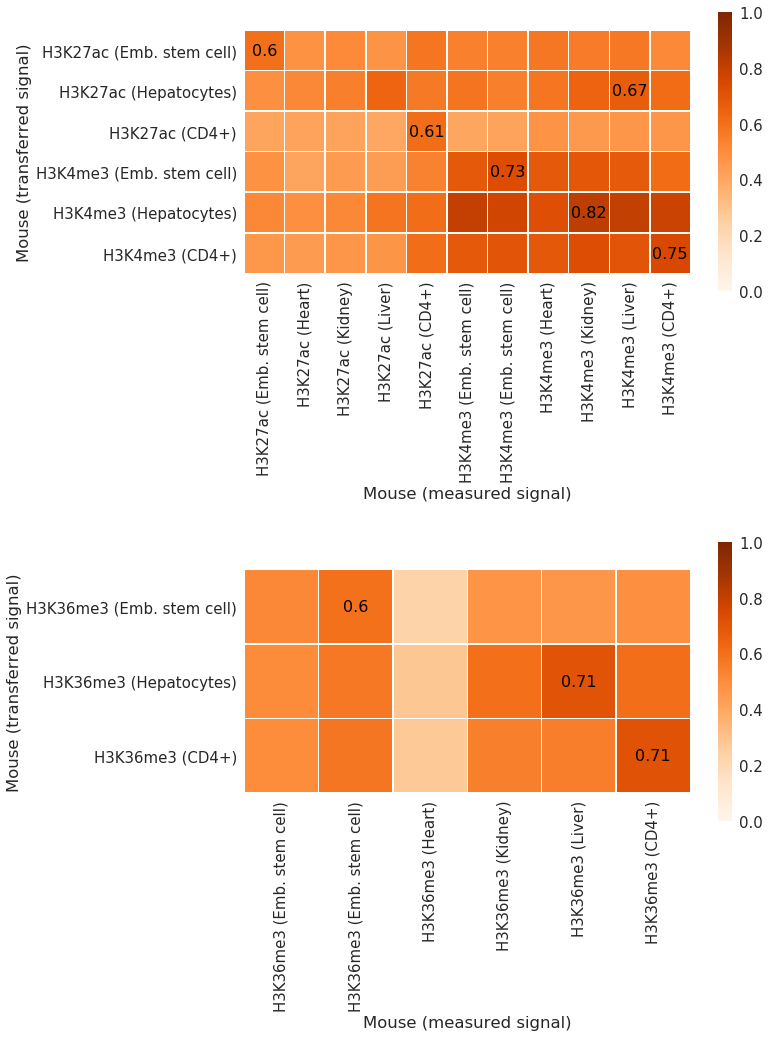

In [6]:
%matplotlib inline

import os as os
import matplotlib.pyplot as plt
from matplotlib import gridspec
import fnmatch as fnm
import json as js
import collections as col

import scipy.cluster.hierarchy as hc
import scipy.spatial.distance as dst
import numpy as np
import pandas as pd
import seaborn as sns

date = '20180415'

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

exec_src_corr = False
exec_map_corr = True

save_figures = True
save_diss = True

conf_folder = '/home/pebert/work/code/mpggit/crossspecies/graphics'
plot_colors = js.load(open(os.path.join(conf_folder, 'colors', 'cs_colors.json'), 'r'))

base_path = '/TL/deep/fhgfs/projects/pebert/thesis/projects/cross_species/processing/norm'
src_corr = os.path.join(base_path, 'task_signal_correlation/sub_roi')
map_corr = os.path.join(base_path, 'task_signal_mapping/mapcorr/corr_roi')

outfolder = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/crossspecies/figures/pub'
diss_folder = '/home/pebert/work/code/mpggit/dissertation/Figures'


prom_marks = ['H3K4me3', 'H3K27ac']
body_marks = ['H3K36me3']

# color_map = "YlOrRd"
color_map = 'Oranges'


def load_json(fpath):
    collector = []
    measure = 'pearson'
    with open(fpath, 'r') as dump:
        data = js.load(dump)['correlations']
        for chrom, info in data:
            collector.append(info[measure]['stat'])
    return np.median(collector)


def plot_clustermap(dataset, title, xlab, ylab, plot_axis=None, diss_version=False):
    """
    """
    # fix: H3K27ac ESE14 has been used twice to complete
    # the other ESE14 epigenome; remove that entry here
    # from the correlation heatmaps
    drop_records = []
    for c in dataset.columns:
        if ('EE04' in c) and ('H3K27ac' in c):
            drop_records.append(c)
    if drop_records:
        dataset.drop(drop_records, axis=1, inplace=True)
    drop_records = []
    for i in dataset.index.tolist():
        if ('EE04' in i) and ('H3K27ac' in i):
            drop_records.append(i)
    if drop_records:
        dataset.drop(drop_records, axis=0, inplace=True)
    # end of fix
    
    # abbreviation free names
    new_cols = []
    for c in dataset.columns:
        mark, tissue, _ = c.split('_')
        if tissue in ['H1hESC', 'ESE14']:
            tissue = 'esc'
        new_cols.append('..'.join([mark, tissue]))
    dataset.columns = new_cols
    
    tissue_lut = {'H1hesc': 'Emb. stem cell', 'Ese14': 'Emb. stem cell',
                  'Ncd4': 'CD4+', 'Hepa': 'Hepatocytes', 'Esc': 'Emb. stem cell'}
    
    labels = []
    for i in dataset.index:
        mark, tissue, _ = i.split('_')
        tissue = tissue_lut.get(tissue.capitalize(), tissue.capitalize())
        labels.append('{} ({})'.format(mark, tissue))
    dataset.index = labels
    labels = []
    for c in dataset.columns:
        mark, tissue = c.split('..')
        tissue = tissue_lut.get(tissue.capitalize(), tissue.capitalize())
        labels.append('{} ({})'.format(mark, tissue))
    dataset.columns = labels
    
    t_data = dataset.transpose()
    t_data = t_data.drop_duplicates(keep='first')
    dataset = t_data.transpose().transpose()
    
    exart = []
    if plot_axis is None:
        if dataset.shape == (3, 6):
            fig, ax = plt.subplots(figsize=(7, 5))
        elif dataset.shape == (6, 11) or dataset.shape == (11, 11):
            fig, ax = plt.subplots(figsize=(11, 9))
        elif dataset.shape == (6, 6):
            fig, ax = plt.subplots(figsize=(9, 7))
        else:
            raise ValueError('Unexpected dataset shape: {}'.format(dataset.shape))
    else:
        ax = plot_axis
    
#         cm = sns.clustermap(dataset, vmin=0, vmax=1, cmap=color_map, center=0.5, annot=False,
#                             row_cluster=False, col_cluster=False, method='average', metric='euclidean',
#                             square=True)
#        hm_ax = cm.ax_heatmap
        # use heatmaps instead of clustermap to get colorbar closer to main plot
    if dataset.shape[0] == dataset.shape[1]:
        hm_ax = sns.heatmap(dataset, vmin=0, vmax=1, cmap=color_map, center=0.5,
                            square=True, linecolor='white', linewidth=0.5,
                            cbar_kws={'shrink': 0.5}, ax=ax,
                            annot=False, fmt='',
                            annot_kws={'color': 'black', 'fontsize': 16})

    else:
        max_ann = make_max_annotation(dataset)
        hm_ax = sns.heatmap(dataset, vmin=0, vmax=1, cmap=color_map, center=0.5,
                            square=True, linecolor='white', linewidth=0.5,
                            cbar_kws={'shrink': 0.5}, ax=ax,
                            annot=max_ann, fmt='',
                            annot_kws={'color': 'black', 'fontsize': 16})

    if dataset.shape == (3, 6):
        yticks = hm_ax.get_ymajorticklabels()
        for item in yticks:
            item.set_rotation(0)
    elif dataset.shape == (6, 3):
        xticks = hm_ax.get_xmajorticklabels()
        for item in xticks:
            item.set_rotation(90)
    else:
        pass
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    if not diss_version:
        tt = ax.set_title(title, fontsize=20)
        if dataset.shape == (3, 6):
            tt.set_position([0.02, 1.05])
        elif dataset.shape == (6, 11):
            tt.set_position([0.02, 1.025])
        elif dataset.shape == (11, 11):
            tt.set_position([0.02, 1.01])
        elif dataset.shape == (6, 6):
            tt.set_position([0.125, 1.01])
        else:
            raise ValueError('Unexpected dataset shape for title position: {}'.format(dataset.shape))
    if plot_axis is not None:
        return ax
    else:
        return fig, exart


def plot_merged_clustermap(datasets, fig_keys, xlab, ylab, diss_version):
        
    fig = plt.figure(figsize=(10, 20))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])
    top = plt.subplot(gs[0])
    bottom = plt.subplot(gs[1])
    exart = []
    for fk, ax in zip(fig_keys, [top, bottom]):
        title = fk
        data = datasets[fk]
        ax = plot_clustermap(data, title, xlab, ylab, ax, diss_version)
    plt.subplots_adjust(hspace=-0.05)
    return fig, exart


def make_max_annotation(dataset):
    
    ann = pd.DataFrame(np.zeros_like(dataset), dtype=str)
        
    row_maxima = dataset.max(axis=1).round(2)
    for idx, rm in enumerate(row_maxima):
        row_vals = dataset.iloc[idx, :].values.round(2)
        is_max = np.array(np.isclose(row_vals, rm, atol=0.001), dtype=np.bool)
        ann.loc[idx, is_max] = row_vals[is_max].astype(str)
        ann.loc[idx, ~is_max] = ''
    return ann


def run_map_corr():
    if not exec_map_corr:
        return False
    corr_files = os.listdir(map_corr)
    data_collect = dict()
    ax_labels = dict()
    for assm in ['hg19', 'mm9']:
        for region, regname in zip(['reg5p', 'body'], ['promoters', 'bodies']):
            datafiles = fnm.filter(corr_files, '*_{}_*_vs_*{}.json'.format(assm, region))
            rows = col.defaultdict(list)
            for df in datafiles:
                comp = df.split('.')[0].split('_')
                l1 = '_'.join([comp[4], comp[3], comp[1]])
                l2 = '_'.join([comp[9], comp[8], comp[6]])
                if region == 'reg5p':
                    if not (comp[4] in prom_marks and comp[9] in prom_marks):
                        continue
                if region == 'body':
                    if not (comp[4] in body_marks and comp[9] in body_marks):
                        continue
                stat = load_json(os.path.join(map_corr, df))
                rows[l1].append((l2, stat))
            prep = []
            for label, row in rows.items():
                df = pd.DataFrame([[x[1] for x in row]], dtype=np.float32,
                                   columns=[x[0] for x in row], index=[label])
                prep.append(df)
            df = pd.concat(prep, axis=0, ignore_index=False, sort=True)
            df.sort_index(axis=0, inplace=True)
            other = 'mm9' if assm == 'hg19' else 'hg19'
            spec_a = plot_colors['mapping'][assm]['species']
            spec_b = plot_colors['mapping'][other]['species']
            # select for publication
            if not (spec_a == 'mouse' and spec_b == 'human'):
                continue            
            #title = 'Pearson corr. of signal {} to {} (transferred) in gene {}'.format(spec_a, spec_a, regname)
            if regname == 'promoters':
                fig_key = '3A'
            elif regname == 'bodies':
                fig_key = '3B'
            else:
                raise ValueError(regname)
            
            title = 'Figure {}'.format(fig_key)
            ylabel = '{} (transferred signal)'.format(spec_a.capitalize())
            xlabel = '{} (measured signal)'.format(spec_a.capitalize())
            
            # merge subplots into one figure for publication
            data_collect[fig_key] = df
            ax_labels['x'] = xlabel
            ax_labels['y'] = ylabel
            continue
            
            fig, exart = plot_clustermap(df, title, xlabel, ylabel, save_diss)
            
            if save_figures:
                if save_diss:
                    outfolder = diss_folder
                    subfolder = 'crossspecies'
                else:
                    subfolder = 'main'
                outname = 'fig_{}_mouse_sigcorr_{}'.format(fig_key, regname)
                
                if not save_diss:
                    outpath = os.path.join(outfolder, subfolder, 'raw', outname + '.svg')
                    fig.savefig(outpath, bbox_inches='tight', extra_artists=exart)

                    outpath = os.path.join(outfolder, subfolder, 'png', outname + '.png')
                    fig.savefig(outpath, bbox_inches='tight', extra_artists=exart, dpi=300)
                
                outpath = os.path.join(outfolder, subfolder, outname + '.pdf')
                fig.savefig(outpath, bbox_inches='tight', extra_artists=exart)

    if len(data_collect) > 0:
        xlabel = ax_labels['x']
        ylabel = ax_labels['y']
        fig, exart = plot_merged_clustermap(data_collect, ['3A', '3B'], xlabel, ylabel, save_diss)
        
        if save_figures:
            if save_diss:
                outfolder = diss_folder
                subfolder = 'crossspecies'
            else:
                subfolder = 'main'
                
            outname = 'fig_3AB_mouse_sigcorr'

            if not save_diss:
                outpath = os.path.join(outfolder, subfolder, 'raw', outname + '.svg')
                fig.savefig(outpath, bbox_inches='tight', extra_artists=exart)

                outpath = os.path.join(outfolder, subfolder, 'png', outname + '.png')
                fig.savefig(outpath, bbox_inches='tight', extra_artists=exart, dpi=300)

            outpath = os.path.join(outfolder, subfolder, outname + '.pdf')
            fig.savefig(outpath, bbox_inches='tight', extra_artists=exart)
                
    return True


def run_src_corr():
    if not exec_src_corr:
        return False
    corr_files = os.listdir(src_corr)
    for assm in ['hg19', 'mm9']:
        for region, regname in zip(['reg5p', 'body'], ['promoters', 'bodies']):
            datafiles = fnm.filter(corr_files, '*_{}_*_{}.json'.format(assm, region))
            rows = col.defaultdict(list)
            for df in datafiles:
                comp = df.split('.')[0].split('_')
                l1 = '_'.join([comp[4], comp[3], comp[1]])
                l2 = '_'.join([comp[9], comp[8], comp[6]])
                if region == 'reg5p':
                    if not (comp[4] in prom_marks and comp[9] in prom_marks):
                        continue
                if region == 'body':
                    if not (comp[4] in body_marks and comp[9] in body_marks):
                        continue
                stat = load_json(os.path.join(src_corr, df))
                rows[l1].append((l2, stat))
                rows[l2].append((l1, stat))
            prep = []                
            for label, row in rows.items():
                df = pd.DataFrame([[x[1] for x in row]], dtype=np.float32,
                                  columns=[x[0] for x in row], index=[label])
                df = df.loc[:, ~df.columns.duplicated(keep='first')]
                prep.append(df)
            df = pd.concat(prep, axis=0, ignore_index=False)
            df.sort_index(axis=0, inplace=True)
            
            spec_a = plot_colors['mapping'][assm]['species']
            if spec_a != 'mouse':
                continue
            if regname == 'promoters':
                fig_key = 'S3A'
            elif regname == 'bodies':
                fig_key = 'S3B'
            else:
                raise ValueError(regname)
            #title = 'Pearson corr. of signal {} to {} in gene {}'.format(assm, assm, regname)
            title = 'Figure {}'.format(fig_key)
            xlabel = '{} (measured signal)'.format(spec_a.capitalize())
            ylabel = '{} (measured signal)'.format(spec_a.capitalize())
            fig, exart = plot_clustermap(df, title, xlabel, ylabel, save_diss)
            if save_figures:
                outname = 'fig_{}_mouse_sigcorr_{}'.format(fig_key, regname)
                if save_diss:
                    outfolder = diss_folder
                    subfolder = 'crossspecies'
                else:
                    subfolder = 'supp'
                
                if not save_diss:
                    outpath = os.path.join(outfolder, subfolder, 'raw', outname + '.svg')
                    fig.savefig(outpath, bbox_inches='tight', extra_artists=exart)

                    outpath = os.path.join(outfolder, subfolder, 'png', outname + '.png')
                    fig.savefig(outpath, bbox_inches='tight', extra_artists=exart, dpi=300)
                
                outpath = os.path.join(outfolder, subfolder, outname + '.pdf')
                fig.savefig(outpath, bbox_inches='tight', extra_artists=exart)
    return True


run_map_corr()
run_src_corr()